Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import seaborn as sns
from tensorflow.keras.utils import plot_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img

import warnings
warnings.filterwarnings('ignore')

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
# Let's unzip the data
!unzip "/content/gdrive/My Drive/AIML/CNN/melonama/CNN_assignment.zip" -d '/content/gdrive/My Drive/AIML/CNN/melonama/'

Archive:  /content/gdrive/My Drive/AIML/CNN/melonama/CNN_assignment.zip
  inflating: /content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actin

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    image_size = (img_height,img_width),
    batch_size = batch_size,
    subset = "training"
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    image_size= (img_height, img_width),
    batch_size= batch_size,
    subset='validation'
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

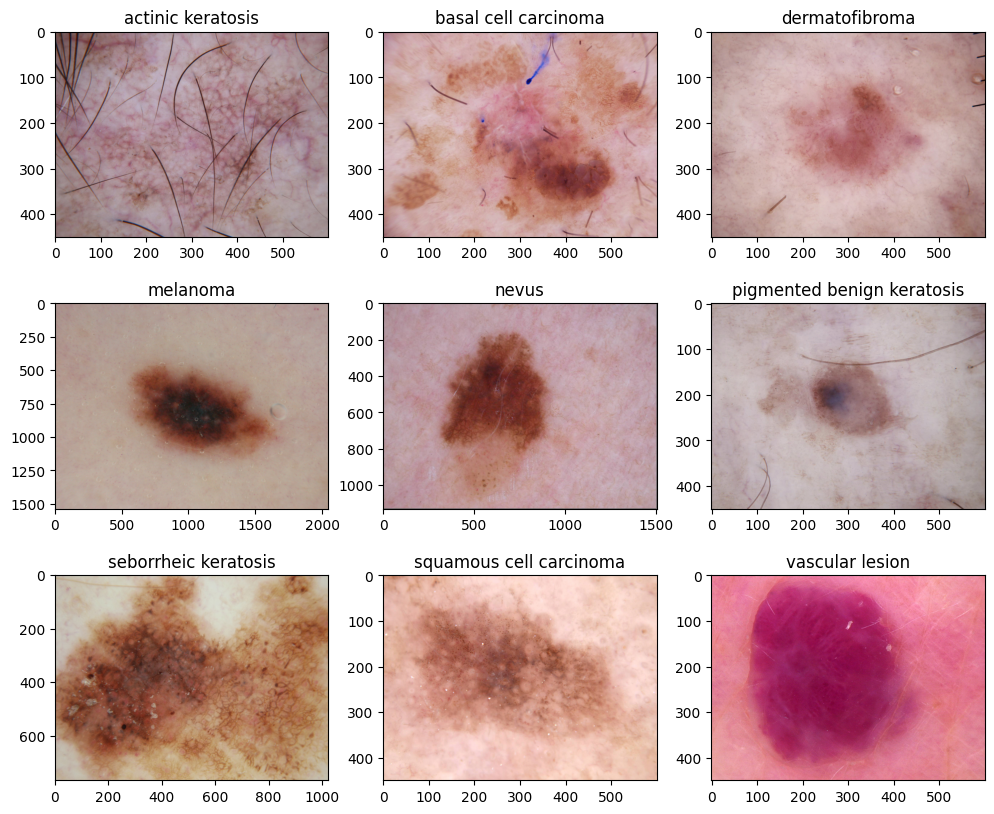

In [14]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

fig = plt.figure(figsize=(12, 10))
for i in range(9):
  plt.subplot(3, 3, i+1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:
### Your code goes here
# Model 1 - Basic CNN Model Architecture

num_class = 9

# A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# Let's add first Convolution layer
model.add(layers.Conv2D(filters = 16, kernel_size=(3,3), padding='same', activation='relu'))

# Let's add pooling layer to down samples
model.add(layers.MaxPooling2D(pool_size=(2,2)))

# Let's add second Convolution layer
model.add(layers.Conv2D(filters = 32, kernel_size=(3,3), padding='same', activation='relu'))

# Let's add another pooling layer to down samples
model.add(layers.MaxPooling2D(pool_size=(2,2)))

# Let's add third Convolution layer
model.add(layers.Conv2D(filters = 64, kernel_size=(3,3), padding='same', activation='relu'))

# Let's add another pooling layer to down samples
model.add(layers.MaxPooling2D(pool_size=(2,2)))

# Let's add fourth Convolution layer
model.add(layers.Conv2D(filters = 128, kernel_size=(3,3), padding='same', activation='relu'))

# Let's add another pooling layer to down samples
model.add(layers.MaxPooling2D(pool_size=(2,2)))

# Let's add Flatten layer. It converts into 1D feature vector and  Flattens all its structure to create a single long feature vector
# Flattens the input. Does not affect the batch size.

model.add(layers.Flatten())

# Let's add fully connected layer (Dense layer)
model.add(layers.Dense(128, activation="relu"))

# Let's add output layer
model.add(layers.Dense(num_class, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [17]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

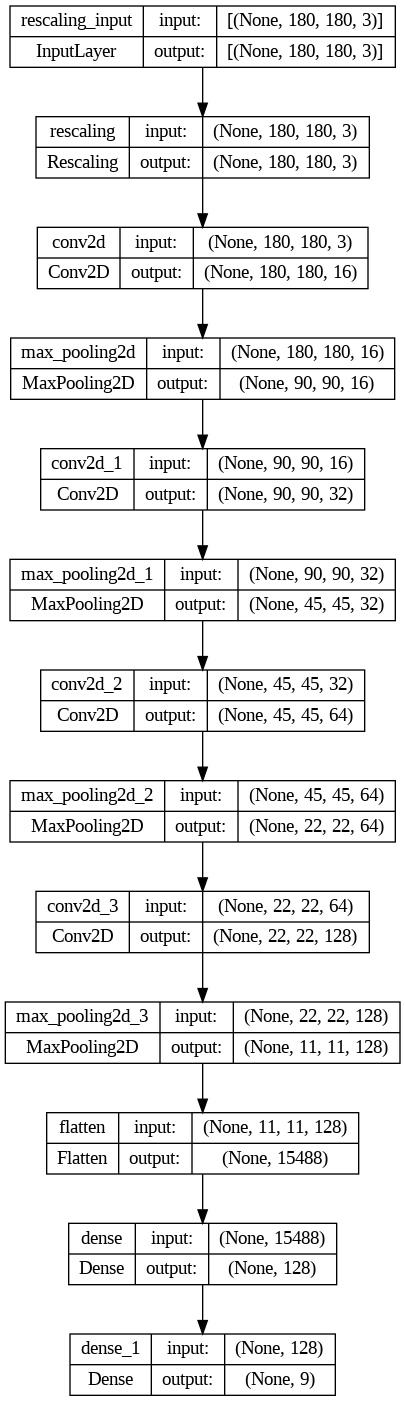

In [19]:
# Let's vizualizing the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Train the model

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 30s 81ms/step - loss: 2.0620 - accuracy: 0.1942 - val_loss: 2.0261 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.9167 - accuracy: 0.2840 - val_loss: 1.6848 - val_accuracy: 0.4251
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.7566 - accuracy: 0.3661 - val_loss: 1.6037 - val_accuracy: 0.4430
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.5012 - accuracy: 0.4810 - val_loss: 1.4930 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3768 - accuracy: 0.5212 - val_loss: 1.4589 - val_accuracy: 0.4877
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3199 - accuracy: 0.5296 - val_loss: 1.4301 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2797 - accuracy: 0.5424 - val_loss: 1.4131 - val_accuracy: 0.5056
Epoch 8/20
5

### Visualizing training results

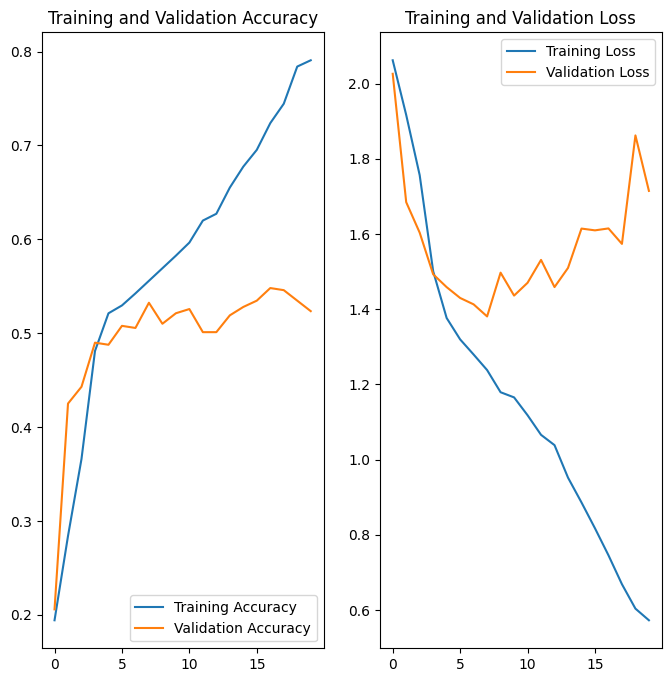

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model is overfitting, with less than 79% as training accuracies and less than 52.3% as validation accuracies.

### Write your findings here

In [22]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

# Let's use horizontal_and_vertical flip method to augment
data_augmentation = Sequential([
  layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomTranslation(1, .5, fill_mode="reflect", interpolation="bilinear", seed=None, fill_value=0.0),
  layers.experimental.preprocessing.RandomCrop(img_height, img_width),
])
     

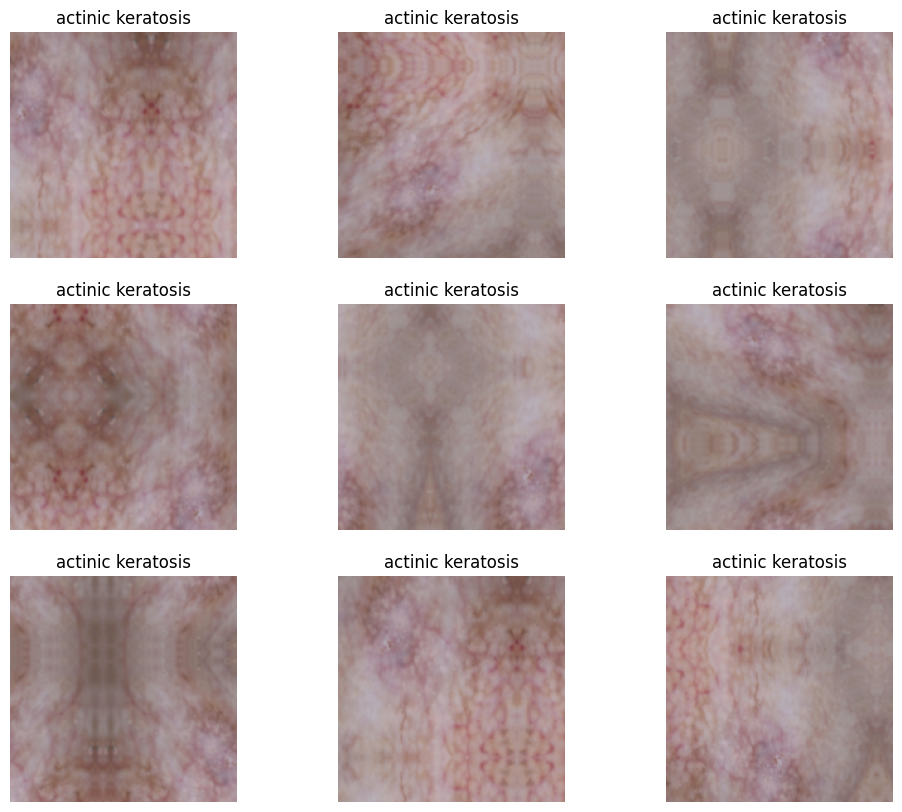

In [23]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(12, 10))
for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[0])
    
# plt.show()

### Todo:
### Create the model, compile and train the model


In [24]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

# Model 2 : Let's add data_augmentation, rescaling and dropout on top of Model 1

num_class = 9

# A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential(data_augmentation)

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# Let's add first Convolution layer
model.add(layers.Conv2D(filters = 16, kernel_size=(3,3), padding='same', activation='relu'))

# Let's add pooling layer to down samples
model.add(layers.MaxPooling2D(pool_size=(2,2)))
# Let us add some dropouts
model.add(layers.Dropout(0.25))

# Let's add second Convolution layer
model.add(layers.Conv2D(filters = 32, kernel_size=(3,3), padding='same', activation='relu'))

# Let's add another pooling layer to down samples
model.add(layers.MaxPooling2D(pool_size=(2,2)))
# Let us add some dropouts
model.add(layers.Dropout(0.25))

# Let's add third Convolution layer
model.add(layers.Conv2D(filters = 64, kernel_size=(3,3), padding='same', activation='relu'))

# Let's add another pooling layer to down samples
model.add(layers.MaxPooling2D(pool_size=(2,2)))
# Let us add some dropouts
model.add(layers.Dropout(0.25))

# Let's add fourth Convolution layer
model.add(layers.Conv2D(filters = 128, kernel_size=(3,3), padding='same', activation='relu'))

# Let's add another pooling layer to down samples
model.add(layers.MaxPooling2D(pool_size=(2,2)))
# Let us add some dropouts
model.add(layers.Dropout(0.25))


# Let's add Flatten layer. It converts into 1D feature vector and  Flattens all its structure to create a single long feature vector
# Flattens the input. Does not affect the batch size.

model.add(layers.Flatten())

# Let's add fully connected layer (Dense layer)
model.add(layers.Dense(128, activation="relu"))
# Let us add some dropouts
model.add(layers.Dropout(0.25))

# Let's add output layer
model.add(layers.Dense(num_class, activation='softmax'))

### Compiling the model

In [25]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [26]:
# Model Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

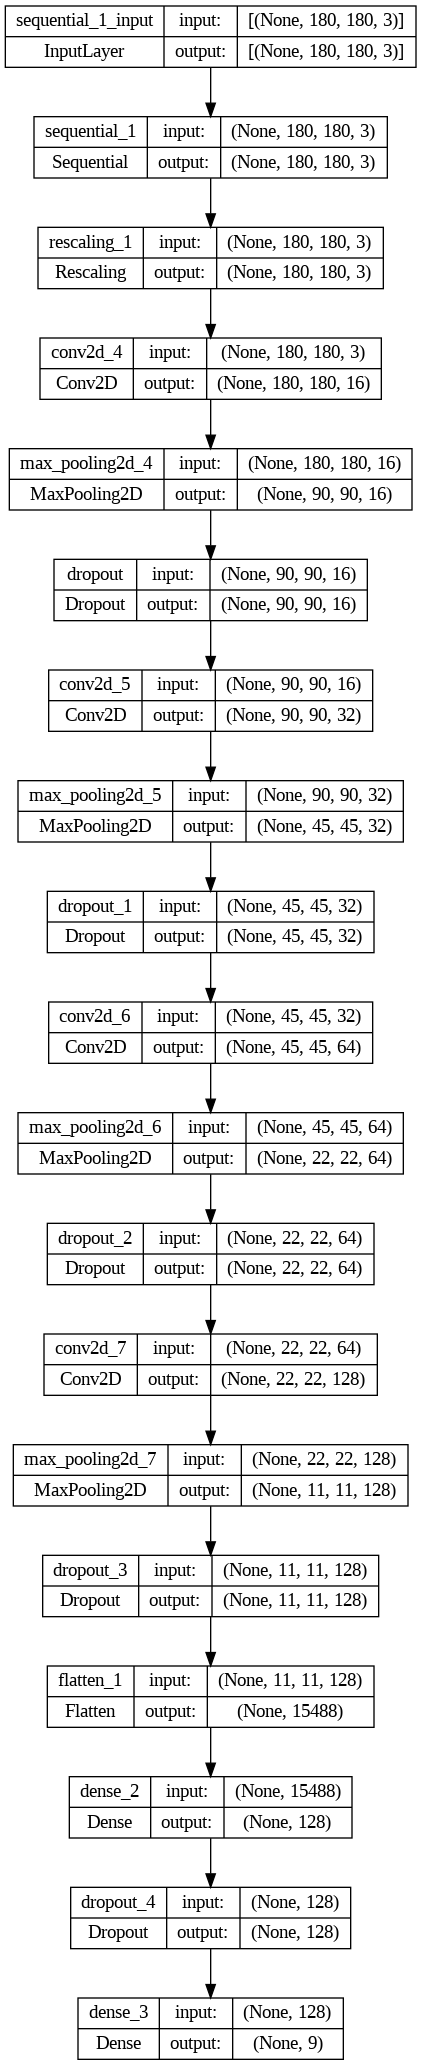

In [27]:
# Let's vizualise the model 
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Training the model

In [28]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 40ms/step - loss: 2.2103 - accuracy: 0.1964 - val_loss: 2.1297 - val_accuracy: 0.2394
Epoch 2/20
56/56 [==============================] - 2s 37ms/step - loss: 2.0133 - accuracy: 0.2243 - val_loss: 1.9775 - val_accuracy: 0.3087
Epoch 3/20
56/56 [==============================] - 2s 37ms/step - loss: 1.8368 - accuracy: 0.3108 - val_loss: 1.7912 - val_accuracy: 0.3468
Epoch 4/20
56/56 [==============================] - 2s 35ms/step - loss: 1.8844 - accuracy: 0.3047 - val_loss: 1.8612 - val_accuracy: 0.2506
Epoch 5/20
56/56 [==============================] - 2s 34ms/step - loss: 1.7479 - accuracy: 0.3465 - val_loss: 1.8116 - val_accuracy: 0.3289
Epoch 6/20
56/56 [==============================] - 2s 34ms/step - loss: 1.7823 - accuracy: 0.3320 - val_loss: 1.7519 - val_accuracy: 0.3826
Epoch 7/20
56/56 [==============================] - 2s 34ms/step - loss: 1.6981 - accuracy: 0.3588 - val_loss: 1.6319 - val_accuracy: 0.3736
Epoch 8/20
56

### Visualizing the results

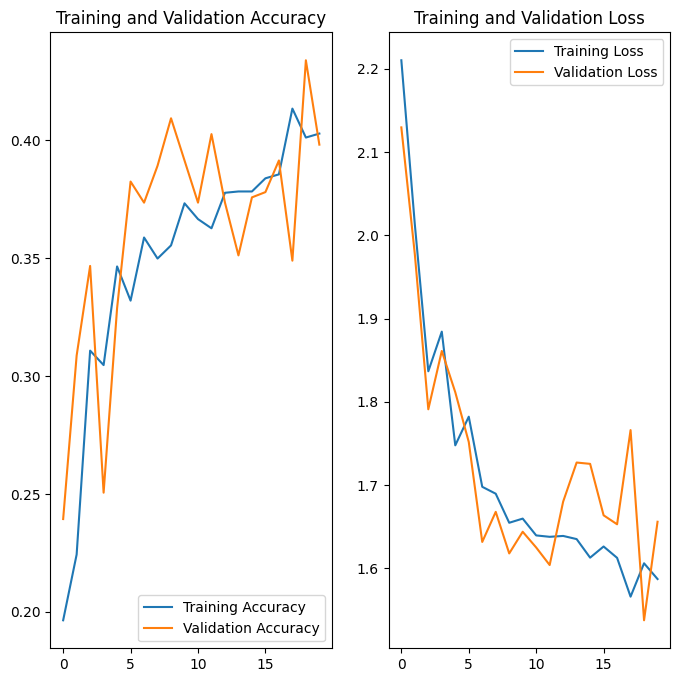

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

##### Model 2 observations:

- Train dataset accuracy has come down.
- Data augumentation helpled to fix model Overritting problem as train and test accuracies has less difference.
- Model is now Underfitting as accuracy is low.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [30]:
## Your code goes here.
path_list = []
label_list = []

for i in class_names:   
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        label_list.append(i)

dataframe_dict_original = dict(zip(path_list, label_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()), columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/My Drive/AIML/CNN/melonama/Ski...,actinic keratosis
1,/content/gdrive/My Drive/AIML/CNN/melonama/Ski...,actinic keratosis
2,/content/gdrive/My Drive/AIML/CNN/melonama/Ski...,actinic keratosis
3,/content/gdrive/My Drive/AIML/CNN/melonama/Ski...,actinic keratosis
4,/content/gdrive/My Drive/AIML/CNN/melonama/Ski...,actinic keratosis
...,...,...
2234,/content/gdrive/My Drive/AIML/CNN/melonama/Ski...,vascular lesion
2235,/content/gdrive/My Drive/AIML/CNN/melonama/Ski...,vascular lesion
2236,/content/gdrive/My Drive/AIML/CNN/melonama/Ski...,vascular lesion
2237,/content/gdrive/My Drive/AIML/CNN/melonama/Ski...,vascular lesion


In [31]:
# Let's visulasie the distribution of the class in training dataset 
def class_distribution(directory):
    count= []
    for path in pathlib.Path(directory).iterdir():
      if path.is_dir():
        count.append(len([name for name in os.listdir(path)
          if os.path.isfile(os.path.join(path, name))]))
    
    # Name of the classes
    sub_directory = [name for name in os.listdir(directory)
      if os.path.isdir(os.path.join(directory, name))]
    
    # Return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


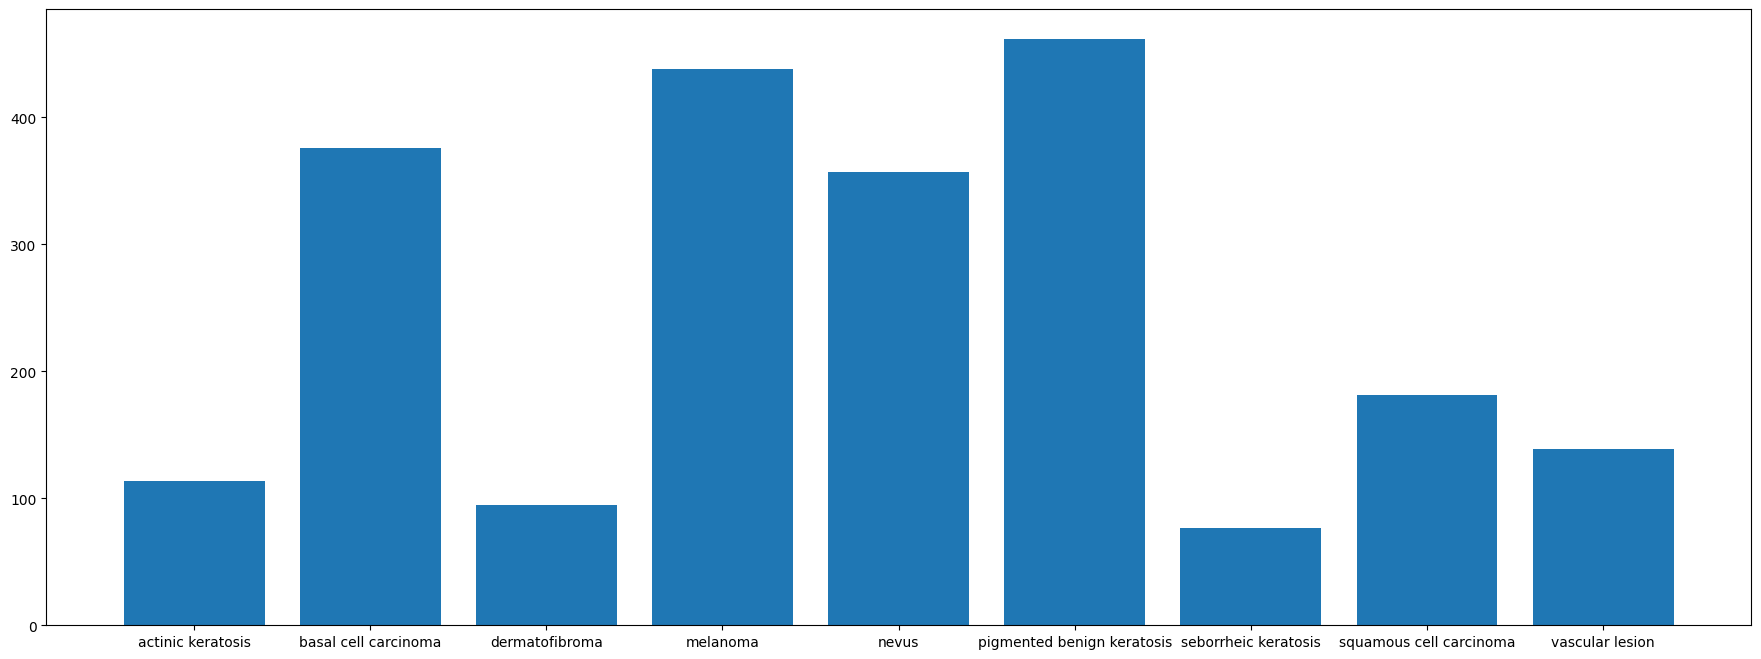

In [32]:
# Let's plot the graph
plt.figure(figsize=(22,8))
plt.bar(df['Class'], df['No. of Image'])
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
- Seborrheic keratosis

#### - Which classes dominate the data in terms proportionate number of samples?

- pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [33]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [35]:
path_to_training_dataset="/content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F30E420B970>: 100%|██████████| 500/500 [00:21<00:00, 22.77 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F30E421EB30>: 100%|██████████| 500/500 [00:20<00:00, 24.12 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F30E42E5180>: 100%|██████████| 500/500 [00:23<00:00, 21.54 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F30E4462410>: 100%|██████████| 500/500 [01:43<00:00,  4.83 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F30E42939A0>: 100%|██████████| 500/500 [01:38<00:00,  5.10 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F30E41BDC30>: 100%|██████████| 500/500 [00:22<00:00, 22.20 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F30E4362560>: 100%|██████████| 500/500 [00:47<00:00, 10.56 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F30E4286740>: 100%|██████████| 500/500 [00:21<00:00, 23.77 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F30E4209660>: 100%|██████████| 500/500 [00:21<00:00, 23.49 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [36]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [43]:
# import glob
from glob import glob

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025992.jpg_b2952ea9-7eae-4ee4-b10a-ffa129a42c0c.jpg',
 '/content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029930.jpg_95ea4992-5fd8-4279-a0db-e3227e73fadb.jpg',
 '/content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030463.jpg_e8efe0b4-b1c2-4b52-91a7-a204167f8c7f.jpg',
 '/content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029133.jpg_cdb3f8cf-472e-4a88-8501-46cad0f923ff.jpg',
 '/content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collabo

In [44]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [46]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [47]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [48]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [49]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [51]:
data_dir_train="/content/gdrive/My Drive/AIML/CNN/melonama/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [52]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Autotuning

In [53]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [54]:
## your code goes here

# Model 3 : Let's rescaling , conv2D, maxpool2D, Dropout and model.add(BatchNormalization())

num_class = 9

model=Sequential([ 
    layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3))
])

# Let's add first Convolution layer
model.add(layers.Conv2D(filters = 16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.Conv2D(filters = 16, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
# Let's add pooling layer to down samples
model.add(layers.MaxPooling2D(pool_size=(2,2)))
# Let us add some dropouts
model.add(layers.Dropout(0.25))

# Let's add second Convolution layer
model.add(layers.Conv2D(filters = 32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
# Let's add another pooling layer to down samples
model.add(layers.MaxPooling2D(pool_size=(2,2)))
# Let us add some dropouts
model.add(layers.Dropout(0.25))

# Let's add third Convolution layer
model.add(layers.Conv2D(filters = 64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.Conv2D(filters = 64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
# Let's add another pooling layer to down samples
model.add(layers.MaxPooling2D(pool_size=(2,2)))
# Let us add some dropouts
model.add(layers.Dropout(0.25))

# Let's add fourth Convolution layer
model.add(layers.Conv2D(filters = 128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(layers.Conv2D(filters = 128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
# Let's add another pooling layer to down samples
model.add(layers.MaxPooling2D(pool_size=(2,2)))
# Let us add some dropouts
model.add(layers.Dropout(0.25))


# Let's add Flatten layer. It converts into 1D feature vector and  Flattens all its structure to create a single long feature vector
# Flattens the input. Does not affect the batch size.

model.add(layers.Flatten())

# Let's add fully connected layer (Dense layer)
model.add(layers.Dense(128, activation="relu"))
# Let us add some dropouts
model.add(layers.Dropout(0.25))

# Let's add output layer
model.add(layers.Dense(num_class, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [55]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [56]:
# Model Summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 178, 178, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 89, 89, 16)      

#### **Todo:**  Train your model

In [57]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 55s 128ms/step - loss: 2.1321 - accuracy: 0.2628 - val_loss: 5.8648 - val_accuracy: 0.1010
Epoch 2/30
169/169 [==============================] - 14s 86ms/step - loss: 1.7219 - accuracy: 0.3498 - val_loss: 4.6416 - val_accuracy: 0.1173
Epoch 3/30
169/169 [==============================] - 15s 86ms/step - loss: 1.6047 - accuracy: 0.3922 - val_loss: 2.2778 - val_accuracy: 0.2450
Epoch 4/30
169/169 [==============================] - 14s 85ms/step - loss: 1.4683 - accuracy: 0.4399 - val_loss: 1.5699 - val_accuracy: 0.3942
Epoch 5/30
169/169 [==============================] - 14s 85ms/step - loss: 1.3350 - accuracy: 0.4707 - val_loss: 1.4408 - val_accuracy: 0.4484
Epoch 6/30
169/169 [==============================] - 14s 84ms/step - loss: 1.2206 - accuracy: 0.5276 - val_loss: 2.3068 - val_accuracy: 0.3430
Epoch 7/30
169/169 [==============================] - 14s 84ms/step - loss: 1.1331 - accuracy: 0.5668 - val_loss: 1.1005 - val_accuracy

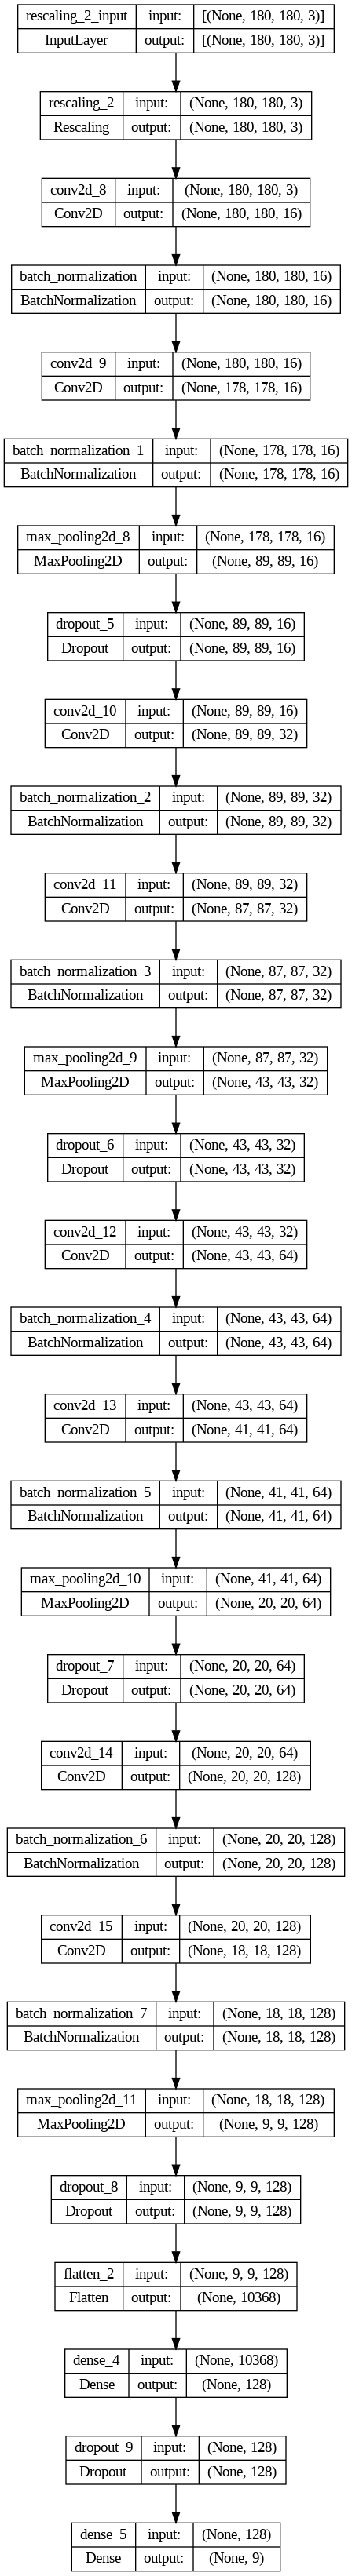

In [58]:
# Let's vizualise the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### **Todo:**  Visualize the model results

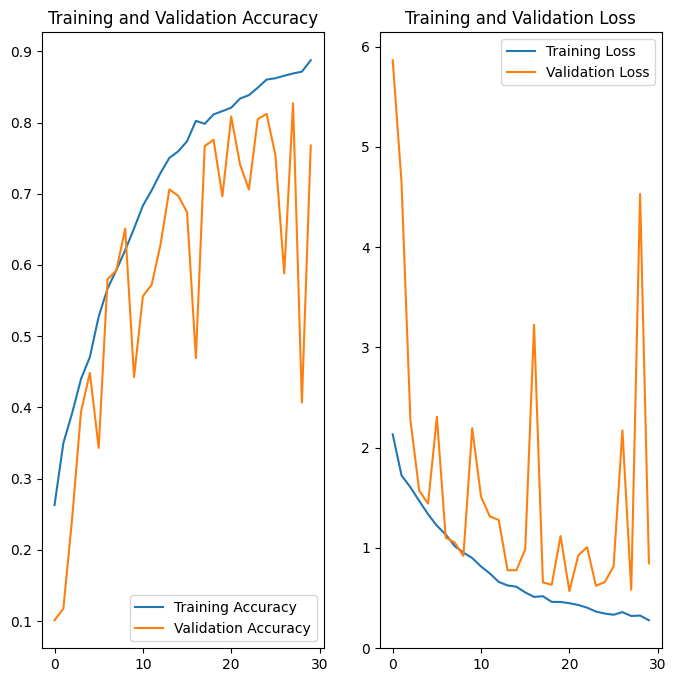

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



## Model 3 Observations :

- Model 3 with Batch Normalization + 30 epoch (As predefined in notebook) with class rebalancing helped to increase the Train and Validation accuracy.]

- Train and Validation accuracy has lesser difference.

- No Sign of Overfitting and underfitting.

Let's try to predict the image of <b>melanoma</b> class using model


In [72]:
# Print class names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


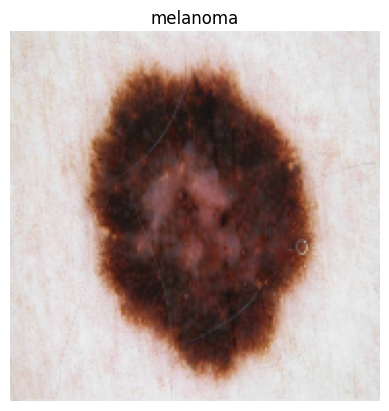

In [76]:
test_image_path = os.path.join(data_dir_test, class_names[3], '*')
test_image = glob(test_image_path)
test_image = load_img(test_image[5], target_size=(180,180,3))
plt.imshow(test_image)
plt.title(class_names[3])
plt.grid(False)
plt.axis("off")
plt.show()

In [77]:
img = np.expand_dims(test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class - "+ class_names[3] +'\n'+ "Predictive Class - "+pred_class )

1/1 [==============================] - 0s 21ms/step
Actual Class - melanoma
Predictive Class - melanoma
